In [1]:
dsi_threshold = 0.5
tf_for_dsi_calc = 2.0
ecid = 511510650
eid = 501836392
# 501836392 501886692 501717543

In [2]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

import warnings;
warnings.simplefilter('ignore');
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
    
# Outputs = [cell_specimen_id, experiment_container_id, pref_dir]


In [3]:
pd.DataFrame(boc.get_ophys_experiments(experiment_container_ids=[ecid]))

,acquisition_age_days,cre_line,donor_name,experiment_container_id,fail_eye_tracking,id,imaging_depth,reporter_line,session_type,specimen_name,targeted_structure
0,109,Cux2-CreERT2,222425,511510650,False,501886692,175,Ai93(TITL-GCaMP6f),three_session_B,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp
1,108,Cux2-CreERT2,222425,511510650,True,501836392,175,Ai93(TITL-GCaMP6f),three_session_A,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp
2,104,Cux2-CreERT2,222425,511510650,True,501717543,175,Ai93(TITL-GCaMP6f),three_session_C,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,VISp


In [4]:
dg_response_filter = get_dg_response_filter_from_saskia()
filtered_cells = get_filtered_cells(cells, dg_response_filter)
filtered_cells = filtered_cells[filtered_cells.experiment_container_id==ecid]
# Filter out based on tf-specific-dsi, rather than allen's global dsi
new_col = []
for index, row in filtered_cells.iterrows():
    polardata_for_this_cell = get_avg_normalized_response(
        boc = boc,
        session_id = eid,
        cell_specimen_id = row.cell_specimen_id,
        temporal_frequency = tf_for_dsi_calc)
    if polardata_for_this_cell is None:
        # Put negative value so dsi selector will ignore this guy.
        new_dsi_cell = -1
    else:
        new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
    new_col.append(new_dsi_cell)
filtered_cells['tf_specific_dsi'] = new_col
filtered_cells = filtered_cells[filtered_cells.tf_specific_dsi > dsi_threshold]


dirs = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]
dirs_to_avg_pairwise_corr = {}
for d1 in dirs:
    for d2 in dirs:
        avg_corr, num_pairs, num_group1, num_group2 = pairwise_dir_avg_temp_corr_one_exp(
            boc, ecid, eid, d1, d2, filtered_cells,
            # use_events
            True,
            # noise_corr_else_avg_temp_corr
            True)
        if avg_corr is None:
            continue
        dirs_to_avg_pairwise_corr[(d1, d2)] = avg_corr
        print ("d1", d1, "d2", d2, "corr", avg_corr, "num_pairs", num_pairs, "num_group1", num_group1, "num_group2", num_group2)

d1 0.0 d2 0.0 corr 0.11048086135101558 num_pairs 20 num_group1 5 num_group2 5
d1 0.0 d2 45.0 corr -0.030074570334955062 num_pairs 30 num_group1 5 num_group2 6
d1 0.0 d2 90.0 corr 0.01110424958857672 num_pairs 5 num_group1 5 num_group2 1
d1 0.0 d2 135.0 corr 0.29735628893746247 num_pairs 5 num_group1 5 num_group2 1
d1 0.0 d2 180.0 corr 0.08710700989274989 num_pairs 10 num_group1 5 num_group2 2
d1 0.0 d2 225.0 corr 0.060787499095825884 num_pairs 40 num_group1 5 num_group2 8
d1 0.0 d2 270.0 corr -0.17832355700949445 num_pairs 5 num_group1 5 num_group2 1
d1 0.0 d2 315.0 corr 0.06417161161516871 num_pairs 20 num_group1 5 num_group2 4
d1 45.0 d2 0.0 corr -0.03007457033495505 num_pairs 30 num_group1 6 num_group2 5
d1 45.0 d2 45.0 corr 0.1073406467223642 num_pairs 30 num_group1 6 num_group2 6
d1 45.0 d2 90.0 corr 0.35660030475268734 num_pairs 6 num_group1 6 num_group2 1
d1 45.0 d2 135.0 corr -0.18484499805748256 num_pairs 6 num_group1 6 num_group2 1
d1 45.0 d2 180.0 corr 0.24054419785766287 nu

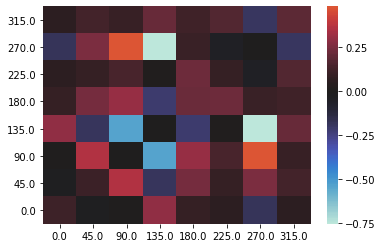

In [5]:
import seaborn as sns;
ser = pd.Series(list(dirs_to_avg_pairwise_corr.values()),
                  index=pd.MultiIndex.from_tuples(dirs_to_avg_pairwise_corr.keys()))
df = ser.unstack().fillna(0)
df = df.sort_index(axis=0 ,ascending=False)
sns.heatmap(df, center=0)

In [6]:
# For each angle, which angle groups are most correlated with it?
for dir1 in dirs:
    dir_partner_to_corr = {}
    for dir2 in dirs:
        key = (dir1, dir2)
        if key in dirs_to_avg_pairwise_corr:
            dir_partner_to_corr[dir2] = dirs_to_avg_pairwise_corr[key]
    desc_sorted_keys = sorted(dir_partner_to_corr, key=dir_partner_to_corr.get, reverse=True)
    print (dir1, desc_sorted_keys)
# The orderings are:
# For 501836392: [2,4,1,1,4,2,3], not bad, for a length of 8. mean ~2.43 ordering.
#   And.. that was when I was using allen dsi. When using our dsi, it got worse :(
# For 501886692: [6,5,7,2,2,3] - v bad
# For 501717543: [7,7,6,7,2] - v bad

0.0 [135.0, 0.0, 180.0, 315.0, 225.0, 90.0, 45.0, 270.0]
45.0 [90.0, 270.0, 180.0, 315.0, 45.0, 225.0, 0.0, 135.0]
90.0 [270.0, 45.0, 180.0, 225.0, 315.0, 0.0, 135.0]
135.0 [0.0, 315.0, 225.0, 45.0, 180.0, 90.0, 270.0]
180.0 [90.0, 45.0, 225.0, 180.0, 315.0, 270.0, 0.0, 135.0]
225.0 [180.0, 315.0, 90.0, 45.0, 225.0, 0.0, 135.0, 270.0]
270.0 [90.0, 45.0, 180.0, 225.0, 0.0, 315.0, 135.0]
315.0 [135.0, 315.0, 225.0, 45.0, 180.0, 90.0, 0.0, 270.0]
